# Example of eddy composite with rotation/scaling coordinate transform
## Method:

  1. Select region within $\pm$ N degrees latitude/longitude of eddy centre. This region should be large enough to include the requested locations in the transformed composite coordinates.
  3. Transform from latitude/longitude coordinates to local cartesian coordinates with unit vectors $\mathbf{e}_i$.
  4. Apply a scaling/rotation coordinate transform such that $\mathbf{e'}_1$ is in the direction of large-scale wind and $|\mathbf{e'}_i|=R_{eddy}$.
  5. Resample data in the transformed composite coordinate system.

## Transformation of basis vectors
The basis vectors in the new coordinate system ($\mathbf{e'_i}$) are derived from the original component vectors as follows:

$\mathbf{e}_i = \frac{1}{R_{eddy}}\mathbf{T}\mathbf{e}_i$,

where $R_{eddy}$ is the radius of the specified eddy, $\theta$ is the required anti-clockwise rotation, and $\mathbf{T}$ is a 2D rotation transformation matrix given by

$\mathbf{T} = \begin{pmatrix} cos\theta & -sin\theta \\ sin\theta & cos\theta \end{pmatrix}$.


## Transforming vector components in new basis back to the original basis.
The linear transformation of vector components is the inverse of the matrix that transforms the basis vectors. Pure rotational transforms are orthogonal and thus $\mathbf{T^T}\equiv\mathbf{T^{-1}}$. The components of a vector in the original basis ($x_i$) can thus be derived from components in the new basis ($x'_i$) using the the following transformation: 

$\begin{pmatrix} x_1 \\ x_2 \end{pmatrix} = R_{eddy}\mathbf{T^T}\begin{pmatrix} x'_1 \\ x'_2 \end{pmatrix},$

where 

$\mathbf{x} = x_1 \mathbf{e}_1 + x_2 \mathbf{e}_2 = x'_1 \mathbf{e}'_1 + x'_2 \mathbf{e}'_2$.

In [106]:
from pathlib import Path

import intake
from dask.diagnostics import ProgressBar

import matplotlib.pyplot as plt
import numpy as np
import scipy

import xarray as xr
xr.set_options(keep_attrs=True)

import eddytransform
import importlib
importlib.reload(eddytransform)

<module 'eddytransform' from '/etc/ecmwf/nfs/dh1_home_a/necr/EERIE/eddy_composites/eddytransform.py'>

## Read data for an example eddy location

In [121]:
# Specify EERIE data
CATALOG = "/home/necr/EERIE/intake_atos/eerie.yaml"
MODEL = "ifs-amip"
DATASET = "2D_24h_0.1deg"
EXP = 'tco1279-eerie_production_202407'
ROOTDIR = "/hpcperm/necr/EERIE/"
DOMAIN_HALF_WIDTH_IN_DEGREES = 10 # Used to select of composite data before resampling to avoid loading global data.
TIME_IDX = 10 # User-specified time index to select data from catalogue (e.g. from tracking algorithm)
EDDY_LON = -71 # User-specified eddy location (e.g. from tracking algorithm)
EDDY_LAT = 39.5

In [122]:
# Read data and select domain centr
catalog = intake.open_catalog(CATALOG)
ds = eddytransform.reshape_latlon_1d_to_latlon_2d(catalog[MODEL][EXP][DATASET].to_dask())

# Select a region surrounding eddy with sufficient buffer for resampling in rotated/scaled coordinates.
ds_region = ds.isel(time=TIME_IDX).sel(
    lon=slice(EDDY_LON-DOMAIN_HALF_WIDTH_IN_DEGREES, EDDY_LON+DOMAIN_HALF_WIDTH_IN_DEGREES),
    lat=slice(EDDY_LAT-DOMAIN_HALF_WIDTH_IN_DEGREES, EDDY_LAT+DOMAIN_HALF_WIDTH_IN_DEGREES),
)

/home/necr/venvs/EERIE_20241203/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


## Transform and resample data

In [123]:
# Parameters coordinate transformation
EDDY_RADIUS = 100 # User-specified eddy radius in km.
AVG_WIND_EDDY_RADIUSES = 2 # Number of eddy radiuses used for calculating direction of large-scale winds. 
RESAMPLE_EDDY_RADIUSES = 3 # Number of eddy radiuses to sample in transformed composite coordinates.
RESAMPLE_DENSITY = 30 # Number of data points per eddy radius in transformed composite coordinates.
UPARAM = "avg_10u"
VPARAM = "avg_10v"
COMPOSITE_PARAM = "avg_sst"

In [124]:
# Create a local cartesian coordinate system with (x,y) specifing distance from eddy in km.
x, y = eddytransform.get_local_cartesian_coords(
    ds_region["lat"].data,
    ds_region["lon"].data,
)

# Create the grid for transformed coordinate system
transformed_x, transformed_y = eddytransform.create_transformed_coordinates(
    RESAMPLE_EDDY_RADIUSES,
    RESAMPLE_DENSITY,
)

# Find direction of large-scale wind (averaged over within specified number of km from eddy centre)
wind_direction_in_radians_from_x = eddytransform.calc_direction_of_average_winds(
    x,
    y,
    ds_region[UPARAM].values,
    ds_region[VPARAM].values,
    distance_from_eddy_threshold=AVG_WIND_EDDY_RADIUSES*EDDY_RADIUS,
    lats = ds_region.lat.values,
)

# Find coordinates of requested locations in local cartesian coordinate system
sample_position_vectors_in_original_coords = eddytransform.create_position_vectors_in_original_coords(
    transformed_x,
    transformed_y,
    wind_direction_in_radians_from_x,
    EDDY_RADIUS,
)

# Resample data into the transformed coordinate system
resampled_data_in_transformed_coords = eddytransform.interpolate_data_to_sample_locations(
    ds_region[COMPOSITE_PARAM].values,
    x,
    y,
    transformed_x,
    transformed_y,
    sample_position_vectors_in_original_coords,
)

## Example plots

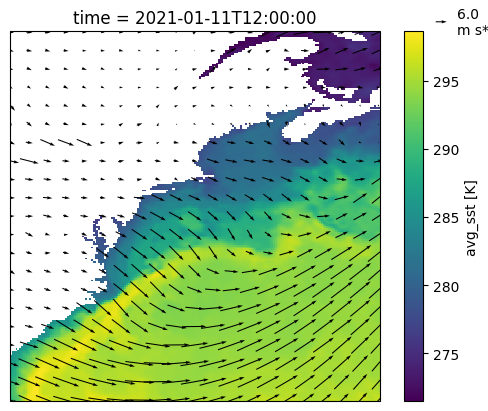

In [125]:
# Plot original data on lat-lon grid
import cartopy.crs as ccrs
ax = plt.axes(projection=ccrs.PlateCarree())
cf = ds_region[COMPOSITE_PARAM].plot(transform=ccrs.PlateCarree())
ds_region_resampled = ds_region.isel(lon=slice(None,None, 10),lat=slice(None,None, 10))
quiver = ds_region_resampled.plot.quiver(x='lon', y='lat', u='avg_10u', v='avg_10v', scale=200)      

Text(0.5, 1.0, 'avg_sst data on local cartesian x-y grid.')

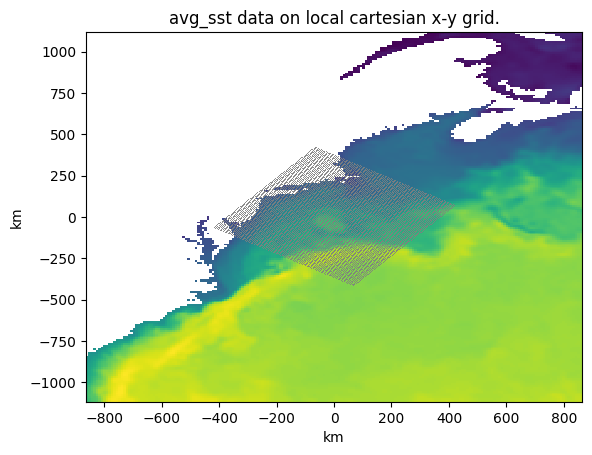

In [126]:
# Plot original data on local cartesian x-y 
plt.pcolormesh(x, y, ds_region[COMPOSITE_PARAM])
plt.xlabel("km")
plt.ylabel("km")

# Add sample locations from rotated/scaled composite grid
plt.plot(
    np.array(sample_position_vectors_in_original_coords[0,:]).squeeze(),
    np.array(sample_position_vectors_in_original_coords[1,:]).squeeze(),
    ",", 
    color="0.5",
    alpha=0.9,
)
plt.title(f"{COMPOSITE_PARAM} data on local cartesian x-y grid.")

Text(0.5, 1.0, 'avg_sst data on rotated/scaled cartesian x-y grid.')

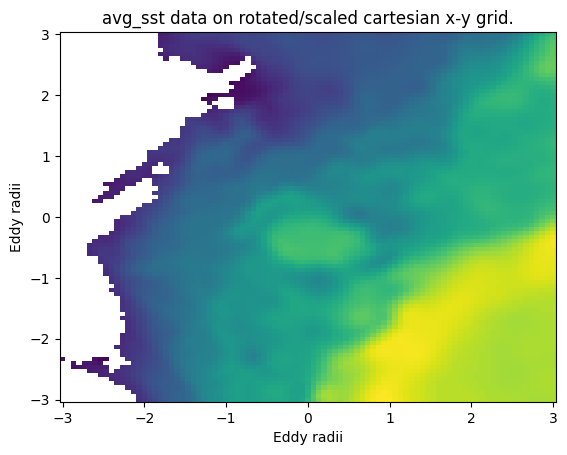

In [127]:
# Plot composte data on rotated/scaled coordinate system 
plt.pcolormesh(transformed_x, transformed_y, resampled_data_in_transformed_coords)
plt.xlabel("Eddy radii")
plt.ylabel("Eddy radii")
plt.title(f"{COMPOSITE_PARAM} data on rotated/scaled cartesian x-y grid.")